### Loading in files & libraries.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from time import time

from collections import defaultdict, Counter

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.utils.extmath import density
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC



import warnings
warnings.filterwarnings("ignore")

In [2]:
complaint_df = pd.read_csv('complaints.csv')

## Complaint Dataframe Exploration

### Initial Introductory Exploration

In [3]:
complaint_df.head()

,Customer Number,Customer Name,Regulated Entity Number,Regulated Entity Name,Mailing Address,Mailing State,Mailing Zip Code,County,Physical Location,Physical City,...,Incident Source,Incident Status,Incident Description,Incident Action Taken,Incident Comment,Material Released,Material Released Amount,Spill Classification,TCEQ Region,Coordinates (Decimal Degrees)
0,NaN,NaN,RN103341053,"RODRIGUEZ, OMAR",NaN,NaN,NaN,CAMERON,NaN,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 15 - HARLINGEN,NaN
1,NaN,NaN,RN103154688,I-10 EAST PLANT,NaN,NaN,NaN,HARRIS,UNSPECIFIED LOCATION,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN
2,NaN,NaN,RN104032552,GENERIC INCIDENT ZIP CODE 75050,NaN,NaN,NaN,DALLAS,NaN,GRAND PRARIE,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 04 - DFW METROPLEX,NaN
3,NaN,NaN,RN101280493,COTTON VALLEY RV PARK,NaN,NaN,NaN,NO COUNTY NAME,NaN,NaN,...,NaN,CLOSED,FUEL LEAKING FROM DISPENSER #2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RN104046297,GENERIC INCIDENT ZIP CODE 77550,NaN,NaN,NaN,GALVESTON,NaN,GALVESTON,...,NaN,CLOSED,Smells like sulfur.,Assigned to investigator.,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN


In [4]:
complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215548 entries, 0 to 215547
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Customer Number                192445 non-null  object 
 1   Customer Name                  192445 non-null  object 
 2   Regulated Entity Number        215546 non-null  object 
 3   Regulated Entity Name          215546 non-null  object 
 4   Mailing Address                94682 non-null   object 
 5   Mailing State                  94682 non-null   object 
 6   Mailing Zip Code               94353 non-null   float64
 7   County                         215489 non-null  object 
 8   Physical Location              96982 non-null   object 
 9   Physical City                  178223 non-null  object 
 10  Latitude                       60650 non-null   float64
 11  Longitude                      60650 non-null   float64
 12  Incident Number               

In [5]:
complaint_df.describe(include=object).T

,count,unique,top,freq
Customer Number,192445,33571,CN602295370,41316
Customer Name,192445,33367,GENERIC INCIDENT PRINCIPAL,41316
Regulated Entity Number,215546,47975,RN102610102,5642
Regulated Entity Name,215546,46417,BLUE RIDGE LANDFILL,5642
Mailing Address,94682,29017,2200 FM 521 RD,5642
Mailing State,94682,12,TX,94649
County,215489,255,HARRIS,15205
Physical Location,96982,26356,LOCATED ON 2200 FM 521,5642
Physical City,178223,2098,HOUSTON,7726
Incident Received Date,215548,7275,"Oct 29, 2018",292


In [6]:
complaint_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mailing Zip Code,94353.0,77264.966233,1341.570210,30097.0000,76106.0000,77494.0000,78264.0000,92154.0
Latitude,60650.0,30.659115,1.873095,4.7330,29.5806,30.2181,32.3972,82.8
Longitude,60650.0,97.230869,2.304337,9.8333,95.4319,97.1659,97.9089,107.0
Incident Number,215548.0,211925.007158,114695.755990,2237.0000,116793.7500,203734.5000,312490.0000,413877.0
Incident Priority,211353.0,5.252213,1.813253,1.0000,4.0000,5.0000,6.0000,8.0
Number Complaining,215548.0,1.098122,3.705954,0.0000,1.0000,1.0000,1.0000,1600.0


In [7]:
complaint_df['Media'].value_counts(normalize=True)

Media
WATER    0.405954
AIR      0.355561
WASTE    0.238484
Name: proportion, dtype: float64

In [8]:
# wtf_df = (complaint_df[complaint_df['Material Released Amount'] == '16500 GALLONS'])
# wtf_df.head()

### Water-related Complaints Dataframe

In [9]:
complaint_h2o = (complaint_df[complaint_df['Media'] == 'WATER'])

In [10]:
complaint_h2o = complaint_h2o.drop(columns= ['Incident Number', 'Regulated Entity Number', 'Incident Comment', 'Mailing Address', 'Incident Start Date', 'Latitude', 'Longitude', 'Regulated Entity Name', 'Mailing Zip Code', 'Mailing State', 'Physical City', 'Number Complaining','Incident Source', 'Customer Name', 'Customer Number', 'Receiving Water Body', 'Spill Classification', 'Media', 'Nature', 'Material Released', 'Material Released Amount', 'Coordinates (Decimal Degrees)', 'Incident Action Taken'])

In [11]:
complaint_h2o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85867 entries, 5 to 215547
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County                  85829 non-null  object 
 1   Physical Location       43516 non-null  object 
 2   Incident Priority       84322 non-null  float64
 3   Incident Received Date  85867 non-null  object 
 4   Incident Status Date    85867 non-null  object 
 5   Effect                  85859 non-null  object 
 6   Frequency               85866 non-null  object 
 7   Incident Status         85867 non-null  object 
 8   Incident Description    85669 non-null  object 
 9   TCEQ Region             85759 non-null  object 
dtypes: float64(1), object(9)
memory usage: 7.2+ MB


In [12]:
complaint_h2o['Physical Location'].value_counts()

Physical Location
APPROXIMATELY 5 MILES EAST OF LA VERNIA ON LAKE VIEW CIRCLE                           415
NO LOCATION ON FILE                                                                   227
LOCATED ON 2200 FM 521                                                                193
ARANSAS COUNTY                                                                        174
SILSBEE, TEXAS                                                                        149
                                                                                     ... 
LOCATED E OFF FM 315 9 MI S OF CHANDLER                                                 1
BLOCK A LOT 24                                                                          1
ON RIGHT SIDE OF CR 2230 APPROX. 1.5 MI N OF HWY 80 IN MINEOLA, WOOD COUNTY, TEXAS      1
512 W MAIN ST., BLACKWELL                                                               1
ON 6218 N HIGHWAY 317                                                             

In [13]:
# complaint_h2o['Regulated Entity Number'].duplicated().value_counts()

In [14]:
# complaint_h2o['Incident Number'].duplicated().value_counts()

In [15]:
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,"Jan 10, 2003","Jan 10, 2003",ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,"Mar 20, 2009","Apr 28, 2016",ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,"Aug 09, 2006","Aug 10, 2006",ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,"Aug 18, 2014","Sep 02, 2014",HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,"Aug 26, 2019","Sep 23, 2019",HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [16]:
IRD_date = complaint_h2o["Incident Received Date"]
datetime_object = pd.to_datetime(IRD_date, format='%b %d, %Y')

complaint_h2o["Incident Received Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2009-03-20
10       2006-08-09
21       2014-08-18
29       2019-08-26
            ...    
215525   2007-05-30
215532   2009-09-01
215537   2015-02-13
215545   2012-02-01
215547   2021-12-15
Name: Incident Received Date, Length: 85867, dtype: datetime64[ns]


In [17]:
stat_date = complaint_h2o["Incident Status Date"]
datetime_object = pd.to_datetime(stat_date, format='%b %d, %Y')

complaint_h2o["Incident Status Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2016-04-28
10       2006-08-10
21       2014-09-02
29       2019-09-23
            ...    
215525   2007-09-11
215532   2009-10-19
215537   2015-02-24
215545   2012-02-06
215547   2022-02-02
Name: Incident Status Date, Length: 85867, dtype: datetime64[ns]


In [18]:
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Incident Status

In [19]:
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [20]:
complaint_h2o['Incident Status'].value_counts()

Incident Status
CLOSED      65846
REFERRED    20021
Name: count, dtype: int64

In [21]:
Closed = 'CLOSED'
Referred ='REFERRED'

In [22]:
def action(Incident):
    if Incident in Closed:
        return 1
    if Incident in Referred:
        return 2
    else:
        return 3

In [23]:
complaint_h2o['Incident Status'] = complaint_h2o['Incident Status'].apply(action)

In [24]:
complaint_h2o.loc[complaint_h2o['Incident Status'] == 3]

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region


In [25]:
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [26]:
complaint_h2o = complaint_h2o.dropna(subset = ['Incident Priority'])

In [27]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].astype(int)

### Feature Engineering: Incident Priority

In [28]:
complaint_h2o['Incident Priority'].value_counts()

Incident Priority
5    41732
8    21839
4    13510
3     2577
2     2300
1      935
6      863
7      566
Name: count, dtype: int64

In [29]:
High = [7, 8]
Mid = [4, 5, 6]
Low = [1, 2, 3]

In [30]:
def Rating(Priority):
    if Priority in High:
        return 3
    if Priority in Mid:
        return 2
    if Priority in Low:
        return 1
    else:
        return 4

In [31]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].apply(Rating)

In [32]:
complaint_h2o.loc[complaint_h2o['Incident Status'] == 4]

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region


In [33]:
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,NaN,3,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,2,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,2,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,3,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Region 

In [34]:
complaint_h2o['TCEQ Region'] = complaint_h2o['TCEQ Region'].str.replace("REGION ",'')

In [35]:
complaint_h2o['Region'] = complaint_h2o['TCEQ Region'].str.split(" ").str[0]

In [36]:
complaint_h2o.dropna(subset='Region')
complaint_h2o = complaint_h2o.drop(columns=['TCEQ Region'])

In [37]:
complaint_h2o['Region'] = complaint_h2o['Region'].astype(float)

In [38]:
complaint_h2o = complaint_h2o.dropna(subset='Incident Description')

### Trimming Timeline & Exporting Clean Complaint CSV

In [39]:
complaint_clean = complaint_h2o[complaint_h2o['Incident Received Date'] >= '2005-01-01']

In [40]:
complaint_clean = complaint_clean.reset_index(drop=True)

In [41]:
df = complaint_clean[['County', 'Region', 'Incident Priority', 'Incident Status', 'Incident Received Date', 'Incident Status Date', 'Frequency', 'Effect', 'Incident Description']]

In [42]:
df['Description'] = df['Incident Description']
df = df.drop(columns=['Incident Description'])

In [43]:
df.head()

,County,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Frequency,Effect,Description
0,ERATH,4.0,3,1,2009-03-20,2016-04-28,CURRENT,ENVIRONMEN,The Stephevnville office recieved a call about...
1,LEON,9.0,2,1,2006-08-09,2006-08-10,CURRENT,ENVIRONMEN,"Leon County: There is a water outage due to 8""..."
2,TARRANT,4.0,2,2,2014-08-18,2014-09-02,CURRENT,HEALTH,Complainant is concerned about the potential f...
3,LLANO,11.0,3,2,2019-08-26,2019-09-23,CURRENT,HEALTH,Alleged septic system installer operating with...
4,WILLIAMSON,11.0,3,2,2022-04-05,2022-04-18,INTERMITTENT,HEALTH,Complaint alleging wastewater was being discha...


In [44]:
# If you want to export dataset for dashboarding, run this code.

# df.to_csv('clean_complaint.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78193 entries, 0 to 78192
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   County                  78165 non-null  object        
 1   Region                  78133 non-null  float64       
 2   Incident Priority       78193 non-null  int64         
 3   Incident Status         78193 non-null  int64         
 4   Incident Received Date  78193 non-null  datetime64[ns]
 5   Incident Status Date    78193 non-null  datetime64[ns]
 6   Frequency               78192 non-null  object        
 7   Effect                  78186 non-null  object        
 8   Description             78193 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 5.4+ MB


## Master Complaint Dataset EDA

In [46]:
df[['Incident Status Date', 'Incident Status','Region']].loc[df['Incident Priority'] == 3].corr() 


,Incident Status Date,Incident Status,Region
Incident Status Date,1.000000,0.142162,-0.072249
Incident Status,0.142162,1.000000,-0.060014
Region,-0.072249,-0.060014,1.000000


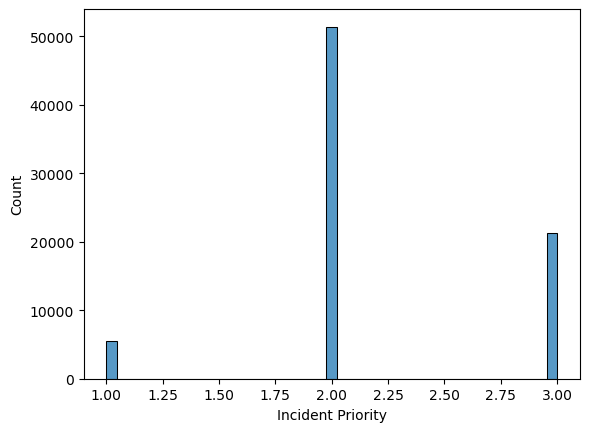

In [47]:
sns.histplot(df['Incident Priority']);

In [48]:
df['Incident Priority'].value_counts()

Incident Priority
2    51425
3    21256
1     5512
Name: count, dtype: int64

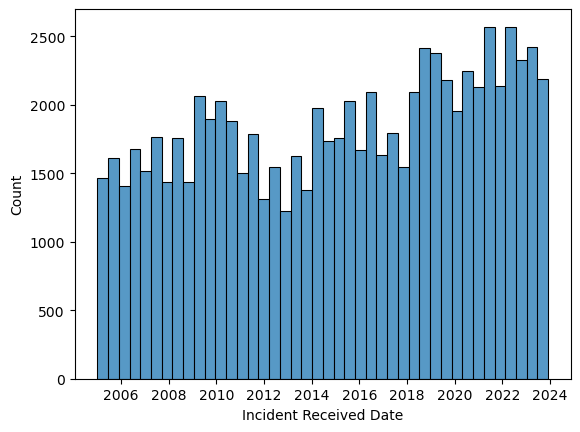

In [49]:
sns.histplot(df['Incident Received Date']);

In [50]:
# sns.relplot(
#     x=df["Incident Received Date"], 
#     y=df["Incident Priority"])

## NLP on Incident Description

### NLP Pre-processing on Incident Complaint Descriptions

In [51]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/marleylopez/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [52]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [53]:
token_pattern = r'(?:(?<![#@])\b\w+\b)|(?:\b\$[\d.]+\b)|(?:(?<![@])\S+)'
tokenizer = RegexpTokenizer(token_pattern)

In [54]:
sw = stopwords.words('english')
#sw.extend(["allege", "complainant","water"])


In [55]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [56]:
lemmatizer = WordNetLemmatizer()
tf_vec = TfidfVectorizer(token_pattern = token_pattern, stop_words=sw)

In [57]:
# Complete dataset
tokenized_docs = [tokenizer.tokenize(doc) for doc in df['Description']]
lower_docs = [[token.lower() for token in doc if token.isalpha()] for doc in tokenized_docs]
sw_docs = [[token for token in doc if token not in sw] for doc in lower_docs]

In [58]:
docs_tagged = [pos_tag(doc) for doc in sw_docs]

In [59]:
wordnet_docs_tagged = [[(token[0], get_wordnet_pos(token[1]))
             for token in doc] for doc in docs_tagged]

In [60]:
docs_lemmed = [[lemmatizer.lemmatize(token[0], token[1]) for token in doc]\
               for doc in wordnet_docs_tagged]

In [61]:
df['Clean Description'] = docs_lemmed

In [62]:
df['Clean Description'] = df['Clean Description'].astype(str)

### NLP Vectorizing on All Descriptions

In [63]:
X = tf_vec.fit_transform([' '.join(doc) for doc in docs_lemmed])
df_tf = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names_out())

In [64]:
df_tf.iloc[315].sort_values(ascending=False)[:10]

drinking       0.555951
report         0.500521
quality        0.424259
concern        0.417158
water          0.238934
complainant    0.171148
pickup         0.000000
pickp          0.000000
pickle         0.000000
picket         0.000000
Name: 315, dtype: float64

### WordCloud for Priority Complaints

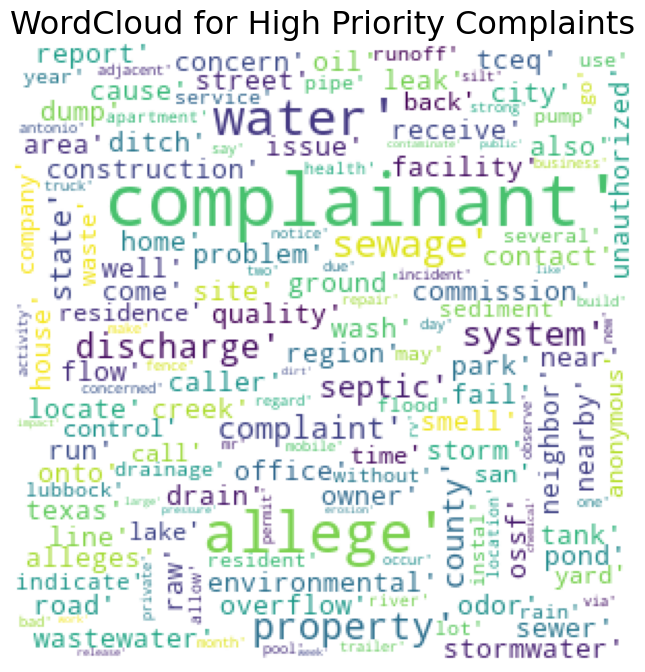

In [65]:
# Selecting High Priority Complaint descriptions
data = df.loc[(df['Incident Priority'] == 3), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(8,10))

# Creating a WordCloud with specific parameters
wc = WordCloud(max_words=150, width=300, height=300, collocations=False, background_color='white').generate(" ".join(data))

# Plotting the WordCloud
plt.title("WordCloud for High Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

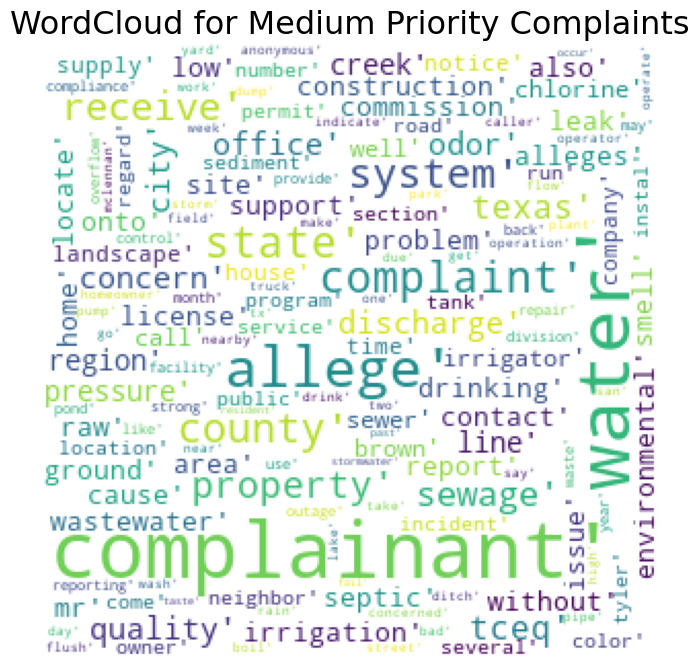

In [66]:
# Selecting medium priority complaint descriptions
data = df.loc[(df['Incident Priority'] == 2), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(10,8))

# Creating a WordCloud with specific parameters
wc = WordCloud(max_words=150, width=300, height=300, collocations=False, background_color='white').generate(" ".join(data))

# Plotting the WordCloud
plt.title("WordCloud for Medium Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

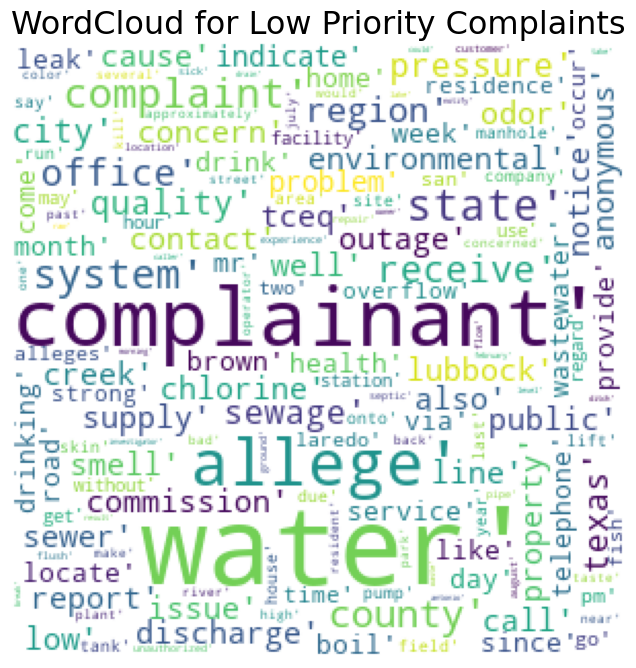

In [67]:
# Selecting low priority complaint descriptions from the lemmatized column.
data = df.loc[(df['Incident Priority'] == 1), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(10,8))

# Creating a WordCloud with specific parameters
wc = WordCloud(max_words=150, width=300, height=300, collocations=False, background_color='white').generate(" ".join(data))

# Plotting the WordCloud
plt.title("WordCloud for Low Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

### NLP Balanced Dataframe

In [68]:
low_priority_rows = df.loc[df['Incident Priority'] == 1]
low_priority_samples = low_priority_rows.sample(n=5500, random_state=42)

med_priority_rows = df.loc[df['Incident Priority'] == 2]
med_priority_samples = med_priority_rows.sample(n=5500, random_state=42)

high_priority_rows = df.loc[df['Incident Priority'] == 3]
high_priority_samples = high_priority_rows.sample(n=5500, random_state=42)

In [69]:
nlp_df = pd.concat([low_priority_samples, med_priority_samples, high_priority_samples])
nlp_df = nlp_df.drop(columns=['County', 'Region', 'Effect', 'Incident Status', 'Incident Received Date', 'Incident Status Date', 'Frequency'], axis=1)
nlp_df = nlp_df.reset_index(drop=True)
nlp_df.head()

,Incident Priority,Description,Clean Description
0,1,"On July 10, 2014 at 11:15 am, an anonymous com...","['july', 'anonymous', 'complainant', 'contact'..."
1,1,The TCEQ San Antonio Region received a complai...,"['tceq', 'san', 'antonio', 'region', 'receive'..."
2,1,Complainant alleges that wastewater lift stati...,"['complainant', 'allege', 'wastewater', 'lift'..."
3,1,"On July 30, 2019, the Region 4-Stephenville Of...","['july', 'region', 'office', 'receive', 'compl..."
4,1,Complainants allege there has been a fish kill...,"['complainant', 'allege', 'fish', 'kill', 'pond']"


In [70]:
label_encoder = LabelEncoder()

nlp_df['Encoded Priority'] = label_encoder.fit_transform(nlp_df['Incident Priority'])

# Display the updated value counts
print(nlp_df['Encoded Priority'].value_counts())

Encoded Priority
0    5500
1    5500
2    5500
Name: count, dtype: int64


In [71]:
nlp_df

,Incident Priority,Description,Clean Description,Encoded Priority
0,1,"On July 10, 2014 at 11:15 am, an anonymous com...","['july', 'anonymous', 'complainant', 'contact'...",0
1,1,The TCEQ San Antonio Region received a complai...,"['tceq', 'san', 'antonio', 'region', 'receive'...",0
2,1,Complainant alleges that wastewater lift stati...,"['complainant', 'allege', 'wastewater', 'lift'...",0
3,1,"On July 30, 2019, the Region 4-Stephenville Of...","['july', 'region', 'office', 'receive', 'compl...",0
4,1,Complainants allege there has been a fish kill...,"['complainant', 'allege', 'fish', 'kill', 'pond']",0
...,...,...,...,...
16495,3,Complainant alleges lack of Best Management Pr...,"['complainant', 'allege', 'lack', 'best', 'man...",2
16496,3,The Complainant is concerned about the ponds l...,"['complainant', 'concern', 'pond', 'locate', '...",2
16497,3,Complainant alleges property owner has been aw...,"['complainant', 'allege', 'property', 'owner',...",2
16498,3,"On April 8, 2010, the Lubbock County Sheriff's...","['april', 'lubbock', 'county', 'sheriff', 'dep...",2


### NLP Modeling

In [72]:
X = nlp_df['Clean Description']
y = nlp_df['Encoded Priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X_train.head()

13117    ['complaint', 'state', 'water', 'bad', 'taste'...
7775     ['complainant', 'contact', 'tceq', 'tyler', 'r...
4153     ['complainant', 'reporting', 'red', 'unknown',...
11430    ['complainant', 'alleges', 'concern', 'regard'...
5903     ['complainant', 'contact', 'tceq', 'tyler', 'r...
Name: Clean Description, dtype: object

In [74]:
# X_train = [' '.join(tokens) for tokens in X_tr]
# X_test = [' '.join(tokens) for tokens in X_te]

### Baseline Multi-class Multinomial Bayes

In [75]:
baseline_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())])

baseline_scores = cross_val_score(baseline_mnb, X_train, y_train, cv=5, scoring="accuracy")

baseline_mnb.fit(X_train, y_train)

baseline_predict_train = cross_val_predict(baseline_mnb,X_train, y_train, cv=5)
baseline_predict_test = cross_val_predict(baseline_mnb, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("MNB accuracy on the train set:", round((accuracy_score(y_train,baseline_predict_train)),2))
print("MNB accuracy on the test set:", round((accuracy_score(y_test,baseline_predict_test)),2))

report_baseline = classification_report(y_test, baseline_predict_test)
print(report_baseline)

MNB accuracy on the train set: 0.61
MNB accuracy on the test set: 0.56
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1099
           1       0.54      0.42      0.47      1140
           2       0.56      0.58      0.57      1061

    accuracy                           0.56      3300
   macro avg       0.56      0.57      0.56      3300
weighted avg       0.56      0.56      0.56      3300



In [76]:
y_hat = baseline_mnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_hat)

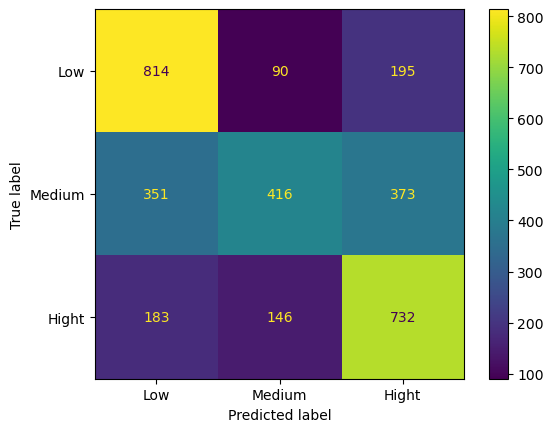

In [77]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low', 'Medium', 'Hight'])
cm_display.plot()
plt.show()

### Gridsearch Multi-Class Multinomial Bayes

In [78]:
# Create a pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes
pipe_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# Define hyperparameter grid for GridSearchCV
param_grid_mnb = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'mnb__alpha': [0.1, 1.0, 10.0]
}

# Perform GridSearchCV
grid_search_mnb = GridSearchCV(pipe_mnb, param_grid_mnb, cv=5, n_jobs=-1)
grid_search_mnb.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search_mnb.best_params_}')

# Best estimator
best_estimator_mnb = grid_search_mnb.best_estimator_

Best hyperparameters: {'mnb__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [79]:
mnb_scores = cross_val_score(best_estimator_mnb, X_train, y_train, cv=5, scoring="accuracy")

best_estimator_mnb.fit(X_train, y_train)

mnb_predict_train = cross_val_predict(best_estimator_mnb,X_train, y_train, cv=5)
mnb_predict_test = cross_val_predict(best_estimator_mnb, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("MNB accuracy on the train set:", round((accuracy_score(y_train,mnb_predict_train)),2))
print("MNB accuracy on the test set:", round((accuracy_score(y_test,mnb_predict_test)),2))

report_mnb = classification_report(y_test, mnb_predict_test)
print(report_mnb)

MNB accuracy on the train set: 0.63
MNB accuracy on the test set: 0.59
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1099
           1       0.57      0.44      0.50      1140
           2       0.57      0.64      0.60      1061

    accuracy                           0.59      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.59      0.59      0.59      3300



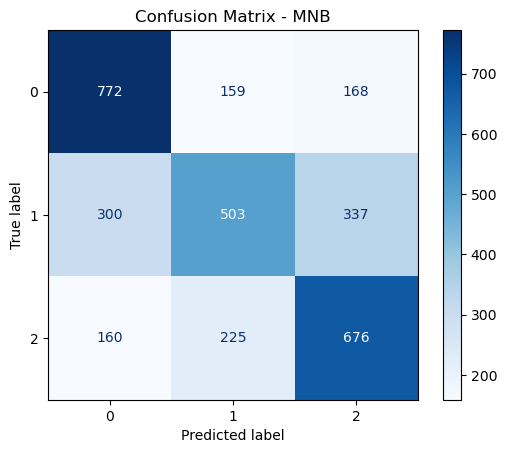

In [80]:
cm_mnb = confusion_matrix(y_test, mnb_predict_test)
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_mnb)
disp_mnb.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix - MNB')
plt.show();

### Multinomial Logistic Regression

In [81]:
# Create a pipeline with TF-IDF Vectorizer and Logistic Regression
pipe_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(multi_class= 'auto', random_state=42))
])

# Define hyperparameter grid for GridSearchCV
param_grid_logreg = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1, 10],
    'logreg__max_iter': [100, 500, 1000]
}

# Perform GridSearchCV
grid_search_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search_logreg.best_params_}')

# Best estimator
best_estimator_logreg = grid_search_logreg.best_estimator_

/Users/marleylopez/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marleylopez/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [ ]:
logreg_scores = cross_val_score(best_estimator_logreg, X_train, y_train, cv=5, scoring="accuracy")

best_estimator_logreg.fit(X_train, y_train)

logreg_predict_train = cross_val_predict(best_estimator_logreg,X_train, y_train, cv=5)
logreg_predict_test = cross_val_predict(best_estimator_logreg, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("Logreg accuracy on the train set:", round((accuracy_score(y_train,logreg_predict_train)),2))
print("Logreg accuracy on the test set:", round((accuracy_score(y_test,logreg_predict_test)),2))

report_logreg = classification_report(y_test, logreg_predict_test)
print(report_logreg)


Logreg accuracy on the train set: 0.66
Logreg accuracy on the test set: 0.59
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1099
           1       0.55      0.51      0.53      1140
           2       0.58      0.60      0.59      1061

    accuracy                           0.59      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.59      0.59      0.59      3300



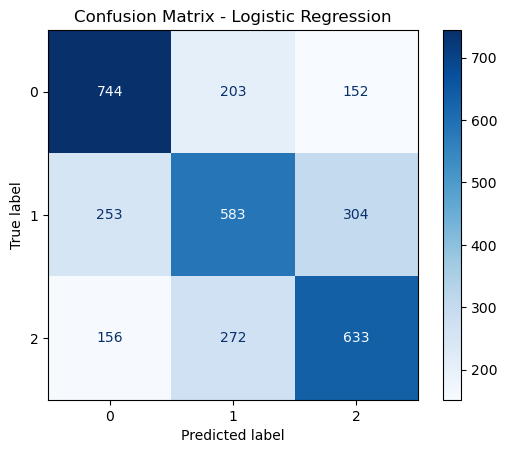

In [ ]:
cm_logreg = confusion_matrix(y_test, logreg_predict_test)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix - Logistic Regression')
plt.show();